In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import time
%matplotlib inline

# Insert mavenn at beginning of path
import sys
path_to_mavenn_local = '../../../../'
sys.path.insert(0,path_to_mavenn_local)

#Load mavenn and check path
import mavenn
print(mavenn.__path__)

# MAVE-NN utilities
from mavenn.src.dev import mutations_to_dataset

['../../../../mavenn']


In [2]:
# Protein sequence determined from the wt coding DNA sequence in Snapgene
# 'AATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCAGATTTGCATCTGTTTATGCTTGGAACAGGAAGAGAATCAGCAACTGTGTTGCTGATTATTCTGTCCTATATAATTCCGCATCATTTTCCACTTTTAAGTGTTATGGAGTGTCTCCTACTAAATTAAATGATCTCTGCTTTACTAATGTCTATGCAGATTCATTTGTAATTAGAGGTGATGAAGTCAGACAAATCGCTCCAGGGCAAACTGGAAAGATTGCTGATTATAATTATAAATTACCAGATGATTTTACAGGCTGCGTTATAGCTTGGAATTCTAACAATCTTGATTCTAAGGTTGGTGGTAATTATAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAGCACACCTTGTAATGGTGTTGAAGGTTTTAATTGTTACTTTCCTTTACAATCATATGGTTTCCAACCCACTAATGGTGTTGGTTACCAACCATACAGAGTAGTAGTACTTTCTTTTGAACTTCTACATGCACCAGCAACTGTTTGTGGACCTAAAAAGTCTACT'
wt_seq = 'NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST'
len(wt_seq)

201

In [3]:
# Save data_df
file_name = '../ace2rbd_data.csv.gz'
data_df = pd.read_csv(file_name, compression='gzip')

Hamming dists: 2.58 +- 1.55


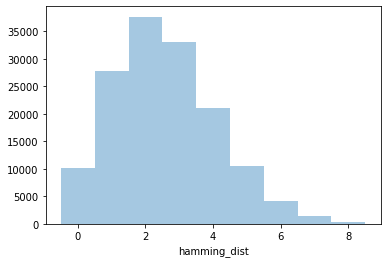

In [4]:
# Histogram hamming distances
print(f"Hamming dists: {data_df['hamming_dist'].mean():.2f} +- {data_df['hamming_dist'].std():.2f}")
sns.distplot(data_df['hamming_dist'], kde=False, bins=np.arange(10)-.5)

In [5]:
# Get mask, if any. Will show which amino acids were not assayed
mask_dict = mavenn.get_mask_dict(data_df['x'], alphabet='protein')
print(mask_dict)

{66: 'EKMQW', 192: 'CEMW', 193: 'CFHKMNQS'}


In [6]:
# Split into training and test sets
ix = data_df['training_set']
training_df = data_df[ix].copy()
test_df = data_df[~ix].copy()

In [19]:
# Infer additive model
model = mavenn.Model(x=training_df['x'].values,
                     y=training_df['y'].values,
                     alphabet='protein',
                     gpmap_type='additive',
                     regression_type='GE',
                     ge_noise_model_type='Gaussian',
                     ge_heteroskedasticity_order=0)

In [20]:
start_time = time.time()
history = model.fit(epochs=50, early_stopping=False, learning_rate=.005)
training_time = time.time()-start_time
print(f'training time: {training_time:.1f} seconds')

Epoch 1/50
2927/2927 [==============================] - 5s 2ms/step - loss: 28.5597 - val_loss: 25.2426
Epoch 2/50
2927/2927 [==============================] - 5s 2ms/step - loss: 24.6666 - val_loss: 25.1808
Epoch 3/50
2927/2927 [==============================] - 5s 2ms/step - loss: 24.6665 - val_loss: 25.1788
Epoch 4/50
2927/2927 [==============================] - 5s 2ms/step - loss: 24.6664 - val_loss: 25.0790
Epoch 5/50
2927/2927 [==============================] - 5s 2ms/step - loss: 24.6670 - val_loss: 25.0955
Epoch 6/50
2927/2927 [==============================] - 5s 2ms/step - loss: 24.6653 - val_loss: 25.0267
Epoch 7/50
2927/2927 [==============================] - 5s 2ms/step - loss: 24.6651 - val_loss: 25.0594
Epoch 8/50
2927/2927 [==============================] - 5s 2ms/step - loss: 24.6645 - val_loss: 25.0077
Epoch 9/50
2927/2927 [==============================] - 5s 2ms/step - loss: 24.6651 - val_loss: 24.9779
Epoch 10/50
2927/2927 [==============================] - 5s 2ms/

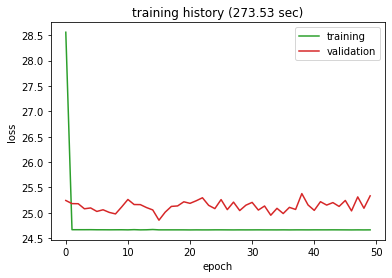

In [21]:
# Extract training loss and validation loss
history_dict = history.history
loss_training = history_dict['loss']
loss_validation = history_dict['val_loss']

# Plot model training history
fig, ax = plt.subplots()
ax.plot(loss_training, color='C2', label='training')
ax.plot(loss_validation, color='C3', label='validation')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.set_title(f"training history ({training_time:.2f} sec)")
ax.legend()

Text(0.5, 1.0, 'mutation effects')

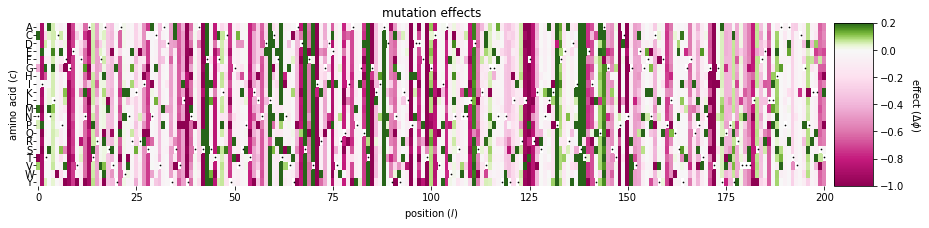

In [22]:
# Set wild-type sequence
wt_seq = 'NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST'

# Get effects of all single-point mutations on phi
dphi_df = mavenn.get_1pt_effects(func=model.x_to_phi,
                                 wt_seq=wt_seq,
                                 alphabet='protein')
# Draw heatmap
fig, ax = plt.subplots(figsize=[15,3])
ax, cb = mavenn.heatmap(dphi_df,
                        ccenter=0,
                        clim=[-1,.2],
                        c_col='c_mut',
                        l_col='l',
                        value_col='dphi',
                        seq=wt_seq,
                        cmap='PiYG',
                        ax=ax)
ax.set_xlabel('position ($l$)')
ax.set_ylabel('amino acid ($c$)')
cb.set_label('effect ($\Delta\phi$)', rotation=-90, va="bottom")
ax.set_title('mutation effects')

In [23]:
# Extract data into np.arrays
x = test_df['x'].values
y = test_df['y'].values

# Compute phi and yhat values
phi = model.x_to_phi(x)
yhat = model.phi_to_yhat(phi)

# Create grid for plotting yhat and yqs
phi_lim = [-5, 2.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)
yhat_grid = model.phi_to_yhat(phi_grid)
yqs_grid = model.yhat_to_yq(yhat_grid, q=[.16,.84])

Text(0.5, 1.0, 'measurement process')

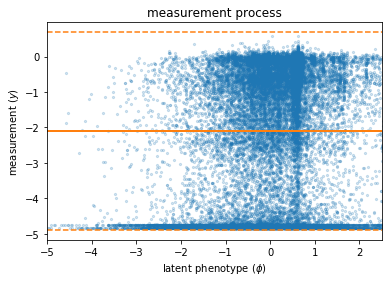

In [24]:
fig, ax = plt.subplots()

ax.scatter(phi, y, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1',
        label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')